In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import scipy as sp
import scipy.stats
from tqdm import tqdm
import itertools
import re
res_digit = r'[0-9]'

from importlib import reload

from sklearn.metrics import classification_report

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn import preprocessing 


from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from skopt import BayesSearchCV
# parameter ranges are specified by one of below
from skopt.space import Real, Categorical, Integer


In [2]:
# This is a hack to make the library in the parent folder available for imoprts
# A better solution is by np8 here:
# https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder
import sys
import os
import inspect

thisdir = sys.path[0]
print(f"thisdir = {thisdir}")
parentdir = os.path.dirname(thisdir)
#print(f"parentdir = {parentdir}")
if not parentdir in sys.path:
    print("Adding parent directory to python path")
    sys.path.insert(1, parentdir)
else:
    print("Skipping adding parent direct to path (there already)")

print(f"sys.path =\n{sys.path}")



thisdir = /home/luke/git/external/predicament/notebooks
Adding parent directory to python path
sys.path =
['/home/luke/git/external/predicament/notebooks', '/home/luke/git/external/predicament', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/luke/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3.10/dist-packages']


In [3]:
## ensure relative path to data directory is sound
# for the notebook we need to modify the BASE_DATA_FOLDER
import os 
os.environ['PREDICAMENT_DATA_DIR'] =  '../data'



In [4]:
from predicament.utils.file_utils import load_dataframe_and_config
import predicament.utils.config_parser
reload(predicament.utils.config_parser)
from predicament.utils.config_parser import config_to_dict

from predicament.utils.config import FEATURED_BASE_PATH
from predicament.data.features import IDEAL_FEATURE_GROUP

from predicament.evaluation.balancing import get_group_label_counts
from predicament.evaluation.balancing import balance_data
from predicament.evaluation.grouping import get_group_assignments
from predicament.evaluation.staging import get_design_matrix
from predicament.evaluation.results import output_model_best_from_results
from predicament.evaluation.results import save_results_df_to_file

from predicament.evaluation.hyperparameters import get_param_scopes
from predicament.evaluation.hyperparameters import get_param_search_object

from predicament.models.mlp_wrappers import ThreeHiddenLayerClassifier


In [5]:
# high level choices
subdir = 'dreem_4secs' # dataset
held_out = 'participant'
is_balanced = True # balance data set
use_only_ideal_features = True # restrict to preferred ideal features
standardise_data = False
max_iter_opt = 200
n_iter = 50 # number of iterations for your search
new_search = True # restarts the search
random_state = 43
use_callback = True

## Load featured data and balance if required

Before running this, you will need to generate featured data. See README file for details. For the variable `subdir` above replace this with the subdirectory name of the featured data.

In [6]:
featured_data_dir = os.path.join(FEATURED_BASE_PATH,subdir)

featured_df, featured_config = load_dataframe_and_config(
    featured_data_dir, 'featured.csv')



Reading dataframe from ../data/featured/dreem_4secs/featured.csv
Reading config from ../data/featured/dreem_4secs/details.cfg


In [7]:
n_channels = featured_config['LOAD']['n_channels']
data_format = featured_config['LOAD']['data_format']
channels = featured_config['LOAD']['channels']
participant_list = featured_config['LOAD']['participant_list']
sample_rate = featured_config['LOAD']['sample_rate']
Fs = sample_rate
window_size = featured_config['LOAD']['window_size']
time = window_size/sample_rate
print(f"sample_rate: {sample_rate}, n_samples = {window_size}, time: {time}s, n_channels: {n_channels}")


sample_rate: 250, n_samples = 1024, time: 4.096s, n_channels: 4


In [8]:
if is_balanced:
    # balance featured data
    subject_condition_counts = get_group_label_counts(featured_df, 'participant', 'condition')
    print(f"before balancing: subject_condition_counts = {subject_condition_counts}")
    featured_df = balance_data(featured_df, group_col='participant', label_col='condition')
    subject_condition_counts = get_group_label_counts(featured_df, 'participant', 'condition')

    print(f"after balancing: subject_condition_counts = {subject_condition_counts}")

before balancing: subject_condition_counts = [[ 813.  461.  461.  461.  461.]
 [ 813.  344.  461.  559.  461.]
 [ 813.  110.  344.  461.  344.]
 [ 813.  227.  461.  461.  461.]
 [ 813.  578.  344.  227.  461.]
 [   0.  110.    0. 1047.  344.]
 [ 832.  422.    0.  504.  364.]
 [ 813.  578.  461.  344.   86.]
 [ 813.  578.    0.  344.  344.]
 [ 803.  325.    0.  551.  348.]
 [ 930.  461.  344.  461.  344.]
 [ 696.  578.  461.  344.  461.]]
after balancing: subject_condition_counts = [[304. 322. 461. 283. 296.]
 [304. 322. 461. 283. 296.]
 [304. 110. 344. 283. 296.]
 [304. 227. 461. 283. 296.]
 [304. 322. 344. 227. 296.]
 [  0. 110.   0. 283. 296.]
 [304. 322.   0. 283. 296.]
 [304. 322. 461. 283.  86.]
 [304. 322.   0. 283. 296.]
 [304. 322.   0. 283. 296.]
 [304. 322. 344. 283. 296.]
 [304. 322. 461. 283. 296.]]


## Define model and hyperparamer search

In [9]:
overrides = dict()
excludes = list()
# the base model to tune
#estimator = SVC()
estimator = GradientBoostingClassifier()
#estimator = RandomForestClassifier()
# max_iter_opt = 1
# estimator = MLPClassifier(max_iter=max_iter_opt)
# estimator = ThreeHiddenLayerClassifier()
# excludes = ['layer3'] # for 2 (hidden) layer MLP (leave empty for 3 layer MLP)
#excludes = ['layer2', 'layer3'] # for 1 (hidden) layer MLP
print(f"estimator = {estimator}")

# search_type = 'random_search'
search_type = 'bayesian_optimization'

# now create the parameter search object and run the hyperparameter search
param_scopes = get_param_scopes(
    search_type, estimator, excludes=excludes, **overrides)
print(f"param_scopes = {param_scopes}")


estimator = GradientBoostingClassifier()
param_scopes = {'learning_rate': Real(low=0.01, high=1.0, prior='log-uniform', transform='identity'), 'n_estimators': Integer(low=50, high=500, prior='uniform', transform='identity'), 'max_depth': Integer(low=3, high=10, prior='uniform', transform='identity'), 'min_samples_split': Integer(low=2, high=20, prior='uniform', transform='identity'), 'min_samples_leaf': Integer(low=1, high=20, prior='uniform', transform='identity'), 'subsample': Real(low=0.5, high=1.0, prior='uniform', transform='identity'), 'max_features': Real(low=0.001, high=1.0, prior='log-uniform', transform='identity')}


## Define data properties and data-split 

In [10]:
feature_set = featured_config['FEATURED']['feature_set']
if use_only_ideal_features:
    feature_set = list(IDEAL_FEATURE_GROUP.intersection(feature_set))
    
print(f"feature_set = {feature_set}")

# extract input data
# use all features in file
feature_types, feature_names, designmtx = get_design_matrix(
    featured_df, feature_set)
# extract labels
labels = featured_df['condition'].values.astype(int)

if standardise_data:
    scaler = preprocessing.StandardScaler().fit(designmtx)
    designmtx = scaler.transform(designmtx)
    
# prepare Hold one group out cross validation
held_out, groups, group_assignments = get_group_assignments(featured_df)
n_groups = len(groups)
# cross validation splits    
group_kfold = GroupKFold(n_splits=n_groups)

feature_set = ['Correlation', 'IQR', 'LempelZivEntropy', 'SD', 'SampleEntropy', 'Mean', 'Hurst', 'arCoeff', 'MaxFreqInd', 'Max', 'MAD', 'LyapunovExponent', 'Min', 'FreqKurtosis', 'MeanFreq']


## Define and Execute hyperparameter search strategy 

In [11]:
# fix to avoid error in BayesSearchCV.fit
import numpy as np
np.int = int

def create_callback_and_storage(param_search):
    intermediate_results = []
    # Define a custom callback function to store intermediate results
    def on_step(optim_result):
        # Store the current state of the optimization process
        intermediate_results.append((optim_result.func_vals, optim_result.x_iters))

        # Print out the best score and best parameters found so far
        best_score = -optim_result.fun
        print("Best score: %s" % best_score)
        print("Best parameters: %s" % optim_result.x)
    return on_step, intermediate_results


param_search  = get_param_search_object(
    search_type, estimator, param_scopes=param_scopes, 
    n_iter = n_iter, cv=group_kfold,
    verbose=2, random_state=random_state, n_jobs=-1,
    fit_params={'X': designmtx, 'y': labels, 'callbacks': None},
    refit=False  # Ensure that the search does not refit the model with the best parameters found so far
)

if use_callback:
    if new_search:
        on_step, intermediate_results = create_callback_and_storage(param_search)
    else:
        param_search.fit_params['search_results'] = intermediate_results
    try:
        # Fit the random search model
        _ = param_search.fit(X=designmtx, y=labels, groups=group_assignments, callback=on_step)
    except Exception as e:
        print("Exception occurred:", str(e))
    finally:
        # Print or process intermediate results even if an error occurs
        print("Intermediate Results:")
        for i, (scores, params) in enumerate(intermediate_results):
            print(f"Iteration {i + 1}: Scores - {scores}, Params - {params}")
        new_search = False
        random_state = np.random.randint(100000)
else:
    _ = param_search.fit(X=designmtx, y=labels, groups=group_assignments)


Fitting 12 folds for each of 1 candidates, totalling 12 fits
Best score: 0.20246530290802742
Best parameters: [0.11022845360378816, 5, 0.004767779380992805, 9, 18, 408, 0.8770216289498161]
Fitting 12 folds for each of 1 candidates, totalling 12 fits
Best score: 0.2290243656256339
Best parameters: [0.0479652461949168, 10, 0.023599192017446292, 12, 17, 61, 0.7198844569805631]
Fitting 12 folds for each of 1 candidates, totalling 12 fits
Best score: 0.23693554666101338
Best parameters: [0.011664040058890733, 7, 0.002470840855529975, 16, 19, 298, 0.9965141136708795]
Fitting 12 folds for each of 1 candidates, totalling 12 fits
Best score: 0.23693554666101338
Best parameters: [0.011664040058890733, 7, 0.002470840855529975, 16, 19, 298, 0.9965141136708795]
Fitting 12 folds for each of 1 candidates, totalling 12 fits
Best score: 0.23693554666101338
Best parameters: [0.011664040058890733, 7, 0.002470840855529975, 16, 19, 298, 0.9965141136708795]
Fitting 12 folds for each of 1 candidates, totalli

Best score: 0.23693554666101338
Best parameters: [0.011664040058890733, 7, 0.002470840855529975, 16, 19, 298, 0.9965141136708795]
Fitting 12 folds for each of 1 candidates, totalling 12 fits
[CV] END learning_rate=0.11022845360378816, max_depth=5, max_features=0.004767779380992805, min_samples_leaf=9, min_samples_split=18, n_estimators=408, subsample=0.8770216289498161; total time= 1.0min
[CV] END learning_rate=0.11022845360378816, max_depth=5, max_features=0.004767779380992805, min_samples_leaf=9, min_samples_split=18, n_estimators=408, subsample=0.8770216289498161; total time= 1.1min
[CV] END learning_rate=0.11022845360378816, max_depth=5, max_features=0.004767779380992805, min_samples_leaf=9, min_samples_split=18, n_estimators=408, subsample=0.8770216289498161; total time=  49.8s
[CV] END learning_rate=0.0479652461949168, max_depth=10, max_features=0.023599192017446292, min_samples_leaf=12, min_samples_split=17, n_estimators=61, subsample=0.7198844569805631; total time=  17.3s
[CV] 

Best score: 0.23868955266769323
Best parameters: [0.01, 3, 0.8712431702112745, 18, 20, 295, 0.6686014583343614]
Fitting 12 folds for each of 1 candidates, totalling 12 fits
[CV] END learning_rate=0.11022845360378816, max_depth=5, max_features=0.004767779380992805, min_samples_leaf=9, min_samples_split=18, n_estimators=408, subsample=0.8770216289498161; total time=  54.9s
[CV] END learning_rate=0.11022845360378816, max_depth=5, max_features=0.004767779380992805, min_samples_leaf=9, min_samples_split=18, n_estimators=408, subsample=0.8770216289498161; total time=  53.5s
[CV] END learning_rate=0.11022845360378816, max_depth=5, max_features=0.004767779380992805, min_samples_leaf=9, min_samples_split=18, n_estimators=408, subsample=0.8770216289498161; total time=  49.1s
[CV] END learning_rate=0.0479652461949168, max_depth=10, max_features=0.023599192017446292, min_samples_leaf=12, min_samples_split=17, n_estimators=61, subsample=0.7198844569805631; total time=  17.0s
[CV] END learning_rate=

Best score: 0.24671841342112533
Best parameters: [0.01, 5, 0.022500248963264004, 18, 20, 415, 0.7021060211974137]
Fitting 12 folds for each of 1 candidates, totalling 12 fits
Best score: 0.24671841342112533
Best parameters: [0.01, 5, 0.022500248963264004, 18, 20, 415, 0.7021060211974137]
Fitting 12 folds for each of 1 candidates, totalling 12 fits
Best score: 0.24671841342112533
Best parameters: [0.01, 5, 0.022500248963264004, 18, 20, 415, 0.7021060211974137]
Fitting 12 folds for each of 1 candidates, totalling 12 fits
Best score: 0.24671841342112533
Best parameters: [0.01, 5, 0.022500248963264004, 18, 20, 415, 0.7021060211974137]
Fitting 12 folds for each of 1 candidates, totalling 12 fits
Best score: 0.24671841342112533
Best parameters: [0.01, 5, 0.022500248963264004, 18, 20, 415, 0.7021060211974137]
Fitting 12 folds for each of 1 candidates, totalling 12 fits
Best score: 0.24671841342112533
Best parameters: [0.01, 5, 0.022500248963264004, 18, 20, 415, 0.7021060211974137]
Fitting 12 

Best score: 0.24671841342112533
Best parameters: [0.01, 5, 0.022500248963264004, 18, 20, 415, 0.7021060211974137]
Fitting 12 folds for each of 1 candidates, totalling 12 fits
Best score: 0.24671841342112533
Best parameters: [0.01, 5, 0.022500248963264004, 18, 20, 415, 0.7021060211974137]
Fitting 12 folds for each of 1 candidates, totalling 12 fits
[CV] END learning_rate=0.01, max_depth=3, max_features=0.8712431702112745, min_samples_leaf=18, min_samples_split=20, n_estimators=295, subsample=0.6686014583343614; total time=13.1min
[CV] END learning_rate=0.01, max_depth=3, max_features=0.8712431702112745, min_samples_leaf=18, min_samples_split=20, n_estimators=295, subsample=0.6686014583343614; total time=13.2min
[CV] END learning_rate=0.01, max_depth=3, max_features=0.8712431702112745, min_samples_leaf=18, min_samples_split=20, n_estimators=295, subsample=0.6686014583343614; total time=12.8min
[CV] END learning_rate=1.0, max_depth=10, max_features=0.001, min_samples_leaf=1, min_samples_s

Best score: 0.24671841342112533
Best parameters: [0.01, 5, 0.022500248963264004, 18, 20, 415, 0.7021060211974137]
Fitting 12 folds for each of 1 candidates, totalling 12 fits
[CV] END learning_rate=0.01, max_depth=5, max_features=0.022500248963264004, min_samples_leaf=18, min_samples_split=20, n_estimators=415, subsample=0.7021060211974137; total time=  50.2s
[CV] END learning_rate=0.01, max_depth=5, max_features=0.022500248963264004, min_samples_leaf=18, min_samples_split=20, n_estimators=415, subsample=0.7021060211974137; total time=  46.2s
[CV] END learning_rate=0.01, max_depth=5, max_features=0.022500248963264004, min_samples_leaf=18, min_samples_split=20, n_estimators=415, subsample=0.7021060211974137; total time=  50.4s
[CV] END learning_rate=0.01, max_depth=3, max_features=0.5315357746059101, min_samples_leaf=5, min_samples_split=9, n_estimators=481, subsample=0.7150462745467308; total time=14.6min
[CV] END learning_rate=0.01, max_depth=3, max_features=0.5315357746059101, min_sa

Best score: 0.24671841342112533
Best parameters: [0.01, 5, 0.022500248963264004, 18, 20, 415, 0.7021060211974137]
Fitting 12 folds for each of 1 candidates, totalling 12 fits
Best score: 0.24671841342112533
Best parameters: [0.01, 5, 0.022500248963264004, 18, 20, 415, 0.7021060211974137]
Fitting 12 folds for each of 1 candidates, totalling 12 fits
Best score: 0.24671841342112533
Best parameters: [0.01, 5, 0.022500248963264004, 18, 20, 415, 0.7021060211974137]
Fitting 12 folds for each of 1 candidates, totalling 12 fits
Best score: 0.25002490214165357
Best parameters: [0.01, 3, 0.004633648691535043, 20, 2, 500, 0.6977653560862899]
Fitting 12 folds for each of 1 candidates, totalling 12 fits
Best score: 0.25002490214165357
Best parameters: [0.01, 3, 0.004633648691535043, 20, 2, 500, 0.6977653560862899]
Fitting 12 folds for each of 1 candidates, totalling 12 fits
Best score: 0.25002490214165357
Best parameters: [0.01, 3, 0.004633648691535043, 20, 2, 500, 0.6977653560862899]
Fitting 12 fol

Best score: 0.25002490214165357
Best parameters: [0.01, 3, 0.004633648691535043, 20, 2, 500, 0.6977653560862899]
Fitting 12 folds for each of 1 candidates, totalling 12 fits
Best score: 0.25002490214165357
Best parameters: [0.01, 3, 0.004633648691535043, 20, 2, 500, 0.6977653560862899]
Fitting 12 folds for each of 1 candidates, totalling 12 fits
[CV] END learning_rate=0.026798403421325667, max_depth=3, max_features=1.0, min_samples_leaf=11, min_samples_split=2, n_estimators=363, subsample=0.6545609481802812; total time=17.5min
[CV] END learning_rate=0.026798403421325667, max_depth=3, max_features=1.0, min_samples_leaf=11, min_samples_split=2, n_estimators=363, subsample=0.6545609481802812; total time=18.5min
[CV] END learning_rate=0.026798403421325667, max_depth=3, max_features=1.0, min_samples_leaf=11, min_samples_split=2, n_estimators=363, subsample=0.6545609481802812; total time=19.3min
[CV] END learning_rate=0.019776125265428768, max_depth=3, max_features=0.001, min_samples_leaf=5,

Best score: 0.25002490214165357
Best parameters: [0.01, 3, 0.004633648691535043, 20, 2, 500, 0.6977653560862899]
Fitting 12 folds for each of 1 candidates, totalling 12 fits
Best score: 0.25002490214165357
Best parameters: [0.01, 3, 0.004633648691535043, 20, 2, 500, 0.6977653560862899]
Fitting 12 folds for each of 1 candidates, totalling 12 fits
[CV] END learning_rate=0.019776125265428768, max_depth=3, max_features=0.001, min_samples_leaf=5, min_samples_split=9, n_estimators=500, subsample=0.831261182602779; total time=  45.0s
[CV] END learning_rate=0.01, max_depth=4, max_features=0.002349689578697547, min_samples_leaf=20, min_samples_split=14, n_estimators=369, subsample=0.9734555180035281; total time=  41.7s
[CV] END learning_rate=0.01, max_depth=4, max_features=0.002349689578697547, min_samples_leaf=20, min_samples_split=14, n_estimators=369, subsample=0.9734555180035281; total time=  40.2s
[CV] END learning_rate=0.01, max_depth=4, max_features=0.002349689578697547, min_samples_leaf

Best score: 0.25002490214165357
Best parameters: [0.01, 3, 0.004633648691535043, 20, 2, 500, 0.6977653560862899]
Fitting 12 folds for each of 1 candidates, totalling 12 fits
Best score: 0.25002490214165357
Best parameters: [0.01, 3, 0.004633648691535043, 20, 2, 500, 0.6977653560862899]
Fitting 12 folds for each of 1 candidates, totalling 12 fits
Best score: 0.25002490214165357
Best parameters: [0.01, 3, 0.004633648691535043, 20, 2, 500, 0.6977653560862899]
Fitting 12 folds for each of 1 candidates, totalling 12 fits
Best score: 0.25002490214165357
Best parameters: [0.01, 3, 0.004633648691535043, 20, 2, 500, 0.6977653560862899]
Fitting 12 folds for each of 1 candidates, totalling 12 fits
Best score: 0.25002490214165357
Best parameters: [0.01, 3, 0.004633648691535043, 20, 2, 500, 0.6977653560862899]
Fitting 12 folds for each of 1 candidates, totalling 12 fits
Best score: 0.25002490214165357
Best parameters: [0.01, 3, 0.004633648691535043, 20, 2, 500, 0.6977653560862899]
Fitting 12 folds 

In [12]:
param_search.get_params()

{'cv': GroupKFold(n_splits=12),
 'error_score': 'raise',
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'friedman_mse',
 'estimator__init': None,
 'estimator__learning_rate': 0.1,
 'estimator__loss': 'log_loss',
 'estimator__max_depth': 3,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_iter_no_change': None,
 'estimator__random_state': None,
 'estimator__subsample': 1.0,
 'estimator__tol': 0.0001,
 'estimator__validation_fraction': 0.1,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': GradientBoostingClassifier(),
 'fit_params': {'X': array([[-6.03878772e-07, -3.67989791e-07,  1.90588760e-07, ...,
           1.34670850e-01,  1.54427245e-01,  1.80378885e-01],
         [ 3.69181902e-07,  6.83794919e-07,  8.64563664e-07, ...,
      

## Saving and outputing results

In [13]:
result_df = pd.DataFrame(param_search.cv_results_)
i = 0
result_df.insert(i, 'model', str(estimator))
i +=1
result_df.insert(i, 'data format', data_format)
i +=1
result_df.insert(i, 'held out', held_out)
i +=1
result_df.insert(i, 'balanced', is_balanced)
i +=1
result_df.insert(i, 'n_splits', param_search.get_params()['cv'].get_n_splits())
i +=1
result_df.insert(i, 'feature set', str(feature_types))
i +=1
result_df.insert(i, 'window size', window_size)
display(result_df)
results_fname = f'{search_type}_{str(estimator)}'
print(f"Saving to {results_fname}")
save_results_df_to_file(result_df, results_fname)

,model,data format,held out,balanced,n_splits,feature set,window size,mean_fit_time,std_fit_time,mean_score_time,...,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,mean_test_score,std_test_score,rank_test_score
0,GradientBoostingClassifier(),dreem,participant,True,12,"['Correlation', 'IQR', 'LempelZivEntropy', 'SD...",1024,56.739504,5.931536,0.113005,...,0.203617,0.167582,0.239342,0.127801,0.169295,0.154357,0.291727,0.202465,0.059125,48
1,GradientBoostingClassifier(),dreem,participant,True,12,"['Correlation', 'IQR', 'LempelZivEntropy', 'SD...",1024,17.268161,2.569462,0.036170,...,0.238446,0.311126,0.247569,0.157676,0.216598,0.167635,0.358491,0.229024,0.071422,29
2,GradientBoostingClassifier(),dreem,participant,True,12,"['Correlation', 'IQR', 'LempelZivEntropy', 'SD...",1024,68.868634,5.240506,0.099098,...,0.263228,0.402473,0.241586,0.119502,0.230705,0.179253,0.291727,0.236936,0.075913,21
3,GradientBoostingClassifier(),dreem,participant,True,12,"['Correlation', 'IQR', 'LempelZivEntropy', 'SD...",1024,40.405024,2.942913,0.060173,...,0.214334,0.203984,0.237846,0.134440,0.190871,0.144398,0.341074,0.215381,0.064111,38
4,GradientBoostingClassifier(),dreem,participant,True,12,"['Correlation', 'IQR', 'LempelZivEntropy', 'SD...",1024,88.348276,8.669688,0.114764,...,0.158071,0.162088,0.210920,0.163485,0.154357,0.145228,0.303338,0.205875,0.061478,45
5,GradientBoostingClassifier(),dreem,participant,True,12,"['Correlation', 'IQR', 'LempelZivEntropy', 'SD...",1024,84.454889,6.145947,0.155479,...,0.224380,0.263736,0.241586,0.121162,0.214938,0.148548,0.371553,0.226017,0.069073,32
6,GradientBoostingClassifier(),dreem,participant,True,12,"['Correlation', 'IQR', 'LempelZivEntropy', 'SD...",1024,79.459580,6.590330,0.023439,...,0.192230,0.398352,0.219895,0.185892,0.185892,0.227386,0.287373,0.228328,0.069845,31
7,GradientBoostingClassifier(),dreem,participant,True,12,"['Correlation', 'IQR', 'LempelZivEntropy', 'SD...",1024,9.711234,1.801803,0.028551,...,0.222371,0.188187,0.222887,0.158506,0.219917,0.165145,0.333817,0.210505,0.056596,44
8,GradientBoostingClassifier(),dreem,participant,True,12,"['Correlation', 'IQR', 'LempelZivEntropy', 'SD...",1024,21.721088,3.103917,0.042039,...,0.190891,0.196429,0.237846,0.185892,0.166805,0.165145,0.297533,0.202115,0.046981,49
9,GradientBoostingClassifier(),dreem,participant,True,12,"['Correlation', 'IQR', 'LempelZivEntropy', 'SD...",1024,206.385081,6.735154,0.101616,...,0.160750,0.153846,0.309648,0.154357,0.129461,0.131950,0.290276,0.214717,0.088723,40


Saving to bayesian_optimization_GradientBoostingClassifier()
saving to ../data/results/bayesian_optimization_GradientBoostingClassifier()_2024-04-13T06:54:18.csv


In [14]:
_ = output_model_best_from_results(result_df)

GradientBoostingClassifier(): max_test_score= 0.25002490214165357, max_std_test_score= 0.07297271436574973
best params: OrderedDict([('learning_rate', 0.01), ('max_depth', 3), ('max_features', 0.004633648691535043), ('min_samples_leaf', 20), ('min_samples_split', 2), ('n_estimators', 500), ('subsample', 0.6977653560862899)])



In [15]:
label_cols = featured_config['WINDOWED']['label_cols']
feature_types = list(feature_set)
feature_types.sort()
print(f"# Feature Set:\n{feature_types}")
derived_feature_names = []
derived_feature_types = set([])
for f in featured_df.columns:
    if f in label_cols:
        continue
    elif (f[-1] == ']'):
        if (f[:-1].rstrip('0123456789')[-1] == '['):
            f = f[:-1].rstrip('0123456789')[:-1]
    else:
        f = f.rstrip('0123456789')
    for type_ in feature_set:
        if f.startswith(type_):
            derived_feature_types.add(f)
            break
derived_feature_types = list(derived_feature_types)
derived_feature_types.sort()
output = ';'.join(derived_feature_types)
print(f"Derived Feature Types:\n{output}")

# Feature Set:
['Correlation', 'FreqKurtosis', 'Hurst', 'IQR', 'LempelZivEntropy', 'LyapunovExponent', 'MAD', 'Max', 'MaxFreqInd', 'Mean', 'MeanFreq', 'Min', 'SD', 'SampleEntropy', 'arCoeff']
Derived Feature Types:
Correlation;FreqKurtosis;Hurst_C;Hurst_H;IQR;LempelZivEntropy[b=1];LempelZivEntropy[b=2];LyapunovExponent;MAD;Max;MaxFreqInd;Mean;MeanFreq;Min;SD;SampleEntropy[m=2];arCoeff


Text(0, 0.5, 'proportion greater than')

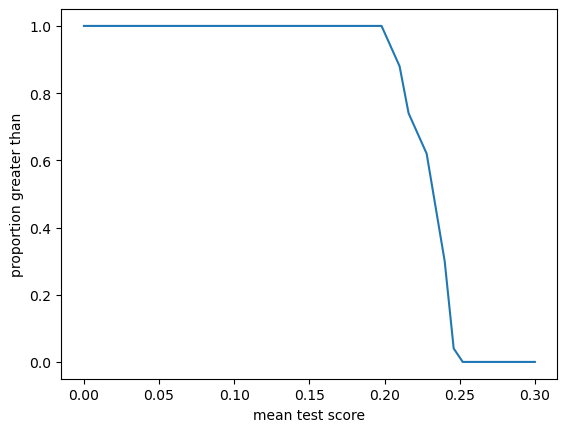

In [16]:
thresholds = np.linspace(0,0.3,51)
N = len(result_df)
props = np.empty(thresholds.size)
for t, thresh in enumerate(thresholds):
    count = np.sum(result_df['mean_test_score'] > thresh)
    props[t] = count/N
plt.plot(thresholds, props)
plt.xlabel("mean test score")
plt.ylabel("proportion greater than")

In [17]:
result_df.columns

Index(['model', 'data format', 'held out', 'balanced', 'n_splits',
       'feature set', 'window size', 'mean_fit_time', 'std_fit_time',
       'mean_score_time', 'std_score_time', 'param_learning_rate',
       'param_max_depth', 'param_max_features', 'param_min_samples_leaf',
       'param_min_samples_split', 'param_n_estimators', 'param_subsample',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'split5_test_score',
       'split6_test_score', 'split7_test_score', 'split8_test_score',
       'split9_test_score', 'split10_test_score', 'split11_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

In [18]:
display_cols = [col for col in result_df.columns if col.startswith('param') or (col =='mean_test_score')]
result_df[result_df['mean_test_score'] >= 0.225][display_cols]

,param_learning_rate,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_subsample,params,mean_test_score
1,0.047965,10,0.023599,12,17,61,0.719884,"{'learning_rate': 0.0479652461949168, 'max_dep...",0.229024
2,0.011664,7,0.002471,16,19,298,0.996514,"{'learning_rate': 0.011664040058890733, 'max_d...",0.236936
5,0.02544,6,0.018579,5,19,437,0.934931,"{'learning_rate': 0.02543950655006558, 'max_de...",0.226017
6,0.010145,4,0.128139,17,7,94,0.997847,"{'learning_rate': 0.010144847279746018, 'max_d...",0.228328
11,1.0,8,0.840066,14,20,157,0.977782,"{'learning_rate': 1.0, 'max_depth': 8, 'max_fe...",0.228477
12,0.01,3,0.871243,18,20,295,0.668601,"{'learning_rate': 0.01, 'max_depth': 3, 'max_f...",0.238690
14,0.01,5,0.0225,18,20,415,0.702106,"{'learning_rate': 0.01, 'max_depth': 5, 'max_f...",0.246718
15,0.01,3,0.531536,5,9,481,0.715046,"{'learning_rate': 0.01, 'max_depth': 3, 'max_f...",0.240550
18,0.01531,4,0.007842,20,2,500,0.509182,"{'learning_rate': 0.015309720076872514, 'max_d...",0.241641
19,0.01,4,0.056869,14,18,500,0.805857,"{'learning_rate': 0.01, 'max_depth': 4, 'max_f...",0.244677


In [19]:
# or just show all rows
result_df[display_cols]

,param_learning_rate,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_subsample,params,mean_test_score
0,0.110228,5,0.004768,9,18,408,0.877022,"{'learning_rate': 0.11022845360378816, 'max_de...",0.202465
1,0.047965,10,0.023599,12,17,61,0.719884,"{'learning_rate': 0.0479652461949168, 'max_dep...",0.229024
2,0.011664,7,0.002471,16,19,298,0.996514,"{'learning_rate': 0.011664040058890733, 'max_d...",0.236936
3,0.061756,5,0.026465,16,14,191,0.788406,"{'learning_rate': 0.061756088200013735, 'max_d...",0.215381
4,0.035774,7,0.032446,8,18,253,0.886501,"{'learning_rate': 0.03577424622203481, 'max_de...",0.205875
5,0.02544,6,0.018579,5,19,437,0.934931,"{'learning_rate': 0.02543950655006558, 'max_de...",0.226017
6,0.010145,4,0.128139,17,7,94,0.997847,"{'learning_rate': 0.010144847279746018, 'max_d...",0.228328
7,0.22569,7,0.001103,16,15,71,0.531744,"{'learning_rate': 0.2256897434142386, 'max_dep...",0.210505
8,0.490333,4,0.001447,2,8,180,0.891777,"{'learning_rate': 0.4903330977186387, 'max_dep...",0.202115
9,0.434115,8,0.131453,17,13,254,0.518528,"{'learning_rate': 0.43411499420882305, 'max_de...",0.214717


[CV] END learning_rate=0.020539137773697314, max_depth=3, max_features=0.001, min_samples_leaf=20, min_samples_split=2, n_estimators=500, subsample=0.904695045886905; total time=  51.2s
[CV] END learning_rate=0.020539137773697314, max_depth=3, max_features=0.001, min_samples_leaf=20, min_samples_split=2, n_estimators=500, subsample=0.904695045886905; total time=  52.3s
[CV] END learning_rate=0.020539137773697314, max_depth=3, max_features=0.001, min_samples_leaf=20, min_samples_split=2, n_estimators=500, subsample=0.904695045886905; total time=  36.9s
[CV] END learning_rate=0.01, max_depth=3, max_features=0.004505857767843888, min_samples_leaf=20, min_samples_split=2, n_estimators=356, subsample=0.5883705861565072; total time=  25.3s
[CV] END learning_rate=0.01, max_depth=3, max_features=0.004505857767843888, min_samples_leaf=20, min_samples_split=2, n_estimators=356, subsample=0.5883705861565072; total time=  23.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=0.0045058577678

[CV] END learning_rate=0.987555727216737, max_depth=6, max_features=0.9559547623309331, min_samples_leaf=19, min_samples_split=13, n_estimators=77, subsample=0.7986547566403169; total time= 8.9min
[CV] END learning_rate=0.01, max_depth=9, max_features=0.0010720866689351088, min_samples_leaf=20, min_samples_split=2, n_estimators=50, subsample=0.5932681250912222; total time=   7.2s
[CV] END learning_rate=0.01, max_depth=9, max_features=0.0010720866689351088, min_samples_leaf=20, min_samples_split=2, n_estimators=50, subsample=0.5932681250912222; total time=   7.8s
[CV] END learning_rate=0.01, max_depth=9, max_features=0.0010720866689351088, min_samples_leaf=20, min_samples_split=2, n_estimators=50, subsample=0.5932681250912222; total time=   7.4s
[CV] END learning_rate=0.10190107981271312, max_depth=3, max_features=0.9523856234233364, min_samples_leaf=16, min_samples_split=15, n_estimators=493, subsample=0.9839874882587218; total time=26.7min
[CV] END learning_rate=0.10190107981271312, m